In [1]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import colors

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

import evcouplings.align, evcouplings.couplings

In [2]:
output = True
N = 9
q = naminoacids

proteome = proteome_path('Human')
seed = 1234
prng = np.random.RandomState(seed)

In [4]:
params = np.load('data/Human_full_k9.npz')
hi = params['hi']
Jij = params['Jij']

In [61]:
datasets = ['train', 'test', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  np.loadtxt('data/%s_matrix.csv.gz' % dataset).astype(int)

KeyboardInterrupt: 

In [5]:
for dataset in datasets:
    print(dataset, sample_matrices[dataset].shape)

train (5702936, 9)
test (5646474, 9)
model (5646474, 9)


In [51]:
fis = {}
fijs = {}
cijs = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fi = frequencies(matrix, num_symbols=q, pseudocount=0.0)
    fis[dataset] = fi
    fij = pair_frequencies(matrix, num_symbols=q, fi=fi, pseudocount=0.0)
    fijs[dataset] = fij
    cij = compute_covariance_matrix(fi=fi, fij=fij)
    cijs[dataset] = cij

In [9]:
fijks = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fijk = triplet_frequencies(matrix, num_symbols=q, pseudocount=0.0)
    fijks[dataset] = fijk

In [12]:
cijks = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fij = fijs[dataset]
    fi = fis[dataset]
    fijk = fijks[dataset]
    cijk = compute_cijk(fijk, fij, fi)
    cijks[dataset] = cijk

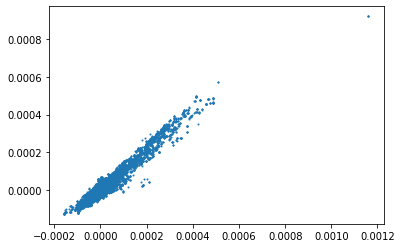

In [13]:
plt.plot(flatten_ijk(cijks['test']), flatten_ijk(cijks['train']), 'o', ms=1)

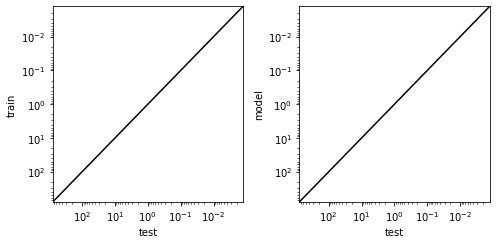

In [45]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)
for i, dataset in enumerate(['train', 'model']):
    plotting.density_scatter(flatten_ijk(cijks['test']),
                             flatten_ijk(cijks[dataset]),
                             trans=lambda x: np.log(x+1e-3),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=axes[i])
    axes[i].set_ylabel(dataset)
for ax in axes:
    max_ = 1.1*flatten_ijk(cijks['test']).max()
    lims = 1/max_, max_
    ax.plot(lims, lims, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('test')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
fig.tight_layout()

In [20]:
jump = lambda x: local_jump(x, q)
x0 = prng.randint(q, size=N)
independent_matrix = mcmcsampler(x0, lambda x: energy_potts(x, hi, np.zeros_like(Jij)), jump, 1e7, nsample=10)

In [21]:
fi_independent = frequencies(independent_matrix, num_symbols=q, pseudocount=0.0)
fij_independent = pair_frequencies(independent_matrix, num_symbols=q, fi=fi_independent, pseudocount=0.0)
fijk_independent = triplet_frequencies(independent_matrix, num_symbols=q, pseudocount=0.0)

In [22]:
cijk_independent = compute_cijk(fijk_independent, fij_independent, fi_independent)

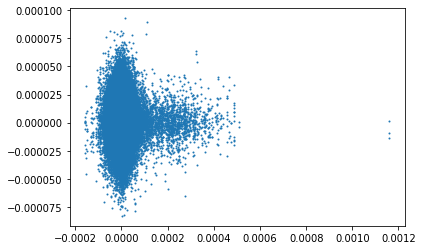

In [23]:
plt.plot(flatten_ijk(cijks['test']), flatten_ijk(cijk_independent), 'o', ms=1)

In [16]:
foldijks = {}
for dataset in datasets:
    fijk = fijks[dataset]
    fi = fis[dataset]
    fold_ijk = fijk / (fi[:, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis] *
                fi[np.newaxis, :, np.newaxis, np.newaxis, :, np.newaxis] *
                fi[np.newaxis, np.newaxis :, np.newaxis, np.newaxis, :])
    foldijks[dataset] = fold_ijk

In [3]:
params = np.load('data/Human_full_k9.npz')
hi = params['hi']
Jij = params['Jij']

In [9]:
list(zip(aminoacids, hi.std(axis=0)))

[('A', 0.0035406579075383795),
 ('C', 0.0014893643088148595),
 ('D', 0.0013892198615577393),
 ('E', 0.0009110189563667492),
 ('F', 0.0013412697278855862),
 ('G', 0.0014000822211791095),
 ('H', 0.002127311629294183),
 ('I', 0.0020652620217782598),
 ('K', 0.0026846894372483626),
 ('L', 0.0011654184849189324),
 ('M', 0.026951582205213515),
 ('N', 0.0012834177758636997),
 ('P', 0.0009682044299691245),
 ('Q', 0.0013840474784771529),
 ('R', 0.001142693073953028),
 ('S', 0.0009424551613649941),
 ('T', 0.0011721207550945312),
 ('V', 0.0008010794265122387),
 ('W', 0.0014400674267044922),
 ('Y', 0.0022629432493179095)]

In [12]:
observables = ['fi', 'fij', 'cij', 'fijk', 'cijk', 'fold_ijk']#, 'fijkl']
observables_dict = {key: dict() for key in observables}
for dataset in ['train', 'test', 'model', 'model_global']:
    params = np.load('data/%s_observables.npz'%dataset)
    for observable in observables:
        observables_dict[observable][dataset] = params[observable]

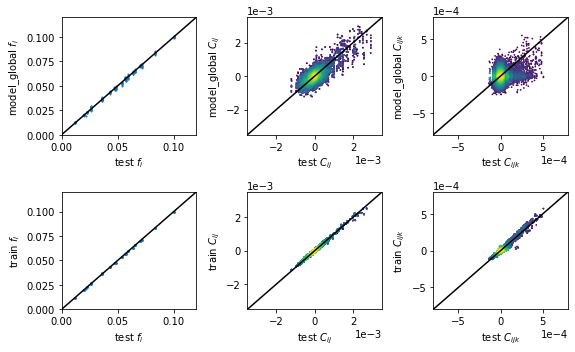

In [13]:
fig, axes = plt.subplots(figsize=(8, 5), ncols=3, nrows=2)

for j, (observable, label, lims, flattener) in enumerate([('fi', '$f_i$', (0, 0.12), np.ravel),
                                               ('cij', '$C_{ij}$', (-0.0035, 0.0035), flatten_ij),
                                               ('cijk', '$C_{ijk}$', (-8e-4, 8e-4), flatten_ijk)]):
    for i, dataset in enumerate(['model_global', 'train']):
        ax = axes[i, j]
        if observable in ['cij', 'cijk']:
            flatten = flatten_ij if observable == 'cij' else flatten_ijk
            plotting.density_scatter(flatten(observables_dict[observable]['test']),
                             flatten(observables_dict[observable][dataset]),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=ax)
        else:
            ax.plot(flattener(observables_dict[observable]['test']),
                    flattener(observables_dict[observable][dataset]),
                    'o', ms=1)
        
        ax.set_xlabel('test %s'%label)
        ax.set_ylabel('%s %s'%(dataset, label))
        ax.plot(lims, lims, 'k')
        ax.set_xlim(*lims)
        ax.set_ylim(*lims)

for ax in axes[:, 1:].flatten():
    ax.ticklabel_format(style='sci', scilimits=(0,0))

fig.tight_layout()

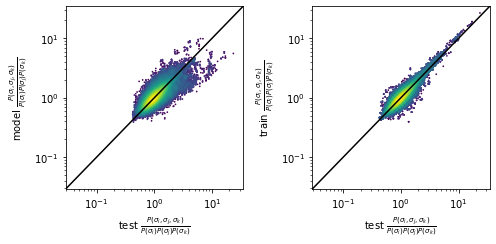

In [11]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)
label = r'$\frac{P(\sigma_i, \sigma_j, \sigma_k)}{P(\sigma_i)P(\sigma_j)P(\sigma_k)}$'
for i, dataset in enumerate(['model', 'train']):
    plotting.density_scatter(flatten_ijk(observables_dict['fold_ijk']['test']),
                             flatten_ijk(observables_dict['fold_ijk'][dataset]),
                             trans=lambda x: np.log(x),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=axes[i])
    axes[i].set_ylabel('%s %s'%(dataset, label))
for ax in axes:
    ax.set_xlabel('test %s'%label)
    
    max_ = 1.1*flatten_ijk(observables_dict['fold_ijk']['test']).max()
    lims = 1/max_, max_
    ax.plot(lims, lims, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
fig.tight_layout()
fig.savefig('fold.png')

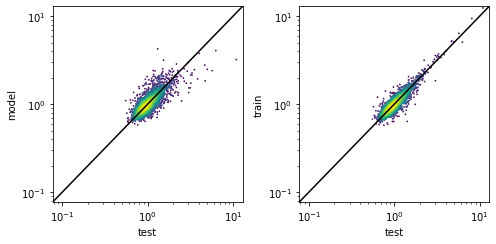

In [49]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)
for i, dataset in enumerate(['model', 'train']):
    indices = 0,4,8
    plotting.density_scatter(observables_dict['fold_ijk']['test'][indices].flatten(),
                             observables_dict['fold_ijk'][dataset][indices].flatten(),
                             trans=lambda x: np.log(x),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=axes[i])
    axes[i].set_ylabel(dataset)
for ax in axes:
    max_ = 1.1*observables_dict['fold_ijk']['test'][indices].flatten().max()
    lims = 1/max_, max_
    ax.plot(lims, lims, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('test')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
fig.tight_layout()

ind 0.0073301421024185645
model 0.0015892616068755262
train 0.0004770915667735209


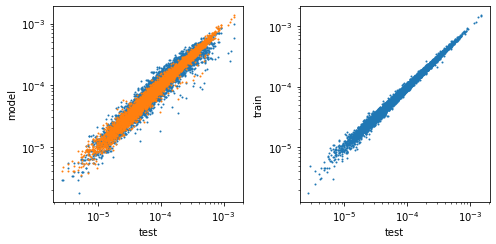

In [12]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)
for i, dataset in enumerate(['model', 'train']):
    if dataset == 'model':
        fi = observables_dict['fi']['train']
        fijk_ind = (fi[:, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis] *
                 fi[np.newaxis, :, np.newaxis, np.newaxis, :, np.newaxis] *
                 fi[np.newaxis, np.newaxis :, np.newaxis, np.newaxis, :])
        test = observables_dict['fijk']['test'][3,4,5,:,:,:].flatten()
        data = fijk_ind[3,4,5,:,:,:].flatten()
        print('ind', calc_jsd(test, data))
        axes[i].plot(test, data, 'o', ms=1)
    test = observables_dict['fijk']['test'][3,4,5,:,:,:].flatten()
    data = observables_dict['fijk'][dataset][3,4,5,:,:,:].flatten()
    print(dataset, calc_jsd(test, data))
    axes[i].plot(test, data, 'o', ms=1)
    axes[i].set_ylabel(dataset)
for ax in axes:
    #max_ = 1.1*flatten_ijk(observables_dict['fijk']['test']).max()
    #lims = 1/max_, max_
    #ax.plot(lims, lims, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('test')
    #ax.set_xlim(*lims)
    #ax.set_ylim(*lims)
fig.tight_layout()

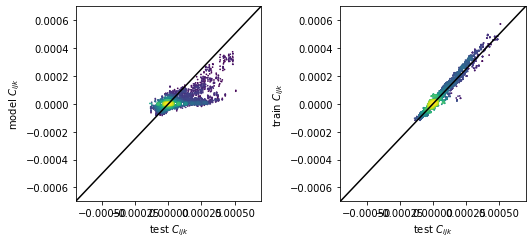

In [30]:
fig, axes = plt.subplots(figsize=(7.5, 3.5), ncols=2)
for i, dataset in enumerate(['model', 'train']):
    plotting.density_scatter(flatten_ijk(observables_dict['cijk']['test']),
                             flatten_ijk(observables_dict['cijk'][dataset]),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=axes[i])
    axes[i].set_ylabel(dataset + ' $C_{ijk}$')
for ax in axes:
    lim = 7e-4
    lims = -lim, lim
    ax.plot(lims, lims, 'k-')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
    ax.set_xlabel('test $C_{ijk}$')
fig.tight_layout()

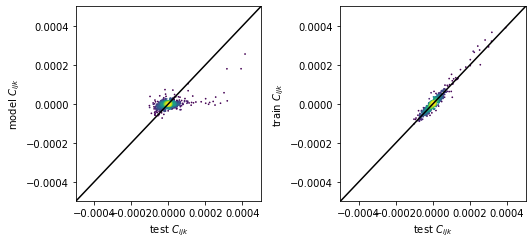

In [55]:
fig, axes = plt.subplots(figsize=(7.5, 3.5), ncols=2)
for i, dataset in enumerate(['model', 'train']):
    indices = 3,4,5
    plotting.density_scatter(observables_dict['cijk']['test'][indices].flatten(),
                             observables_dict['cijk'][dataset][indices].flatten(),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=axes[i])
    axes[i].set_ylabel(dataset + ' $C_{ijk}$')
for ax in axes:
    lim = 5e-4
    lims = -lim, lim
    ax.plot(lims, lims, 'k-')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
    ax.set_xlabel('test $C_{ijk}$')
fig.tight_layout()